In [1]:
from mongodbcredentials import CONNECTION_STRING
from pymongo import MongoClient
import certifi
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
client = MongoClient(CONNECTION_STRING, tlsCAFile=certifi.where())

In [3]:
reddit_facemasks = client.RedditFacemasks
reddit_lockdown = client.RedditLockdown
reddit_pcr = client.RedditPCR
reddit_pfizer = client.RedditPfizer
reddit_quarantine = client.RedditQuarantine
reddit_restrictions = client.RedditRestrictions
reddit_vaccine = client.RedditVaccination

In [4]:
reddit_data = reddit_lockdown.SocialMediaPosts.aggregate([
    { "$group": { "_id": "$subreddit", "count": { "$sum": 1 }}}, 
    { "$sort": { "_id.subreddit":1, "count": -1 }  },
])

In [5]:
def get_top_subreddits(db):
    top_subreddits = db.SocialMediaPosts.aggregate([
        { "$group": { "_id": "$subreddit", "count": { "$sum": 1 }}}, 
        { "$sort": { "_id.subreddit":1, "count": -1 }  },
    ])
    top_subreddits = save_results(top_subreddits)
    return top_subreddits[:10]

In [6]:
def save_results(data):
    results = []
    for result in data:
        dictionary = {}
        dictionary['subreddit'] = result['_id']
        dictionary['count'] = result['count']
        results += [dictionary]

    return results

In [7]:
facemasks_count = get_top_subreddits(reddit_facemasks)
lockdown_count = get_top_subreddits(reddit_lockdown)
pcr_count = get_top_subreddits(reddit_pcr)
pfizer_count = get_top_subreddits(reddit_pfizer)
quarantine_count = get_top_subreddits(reddit_quarantine)
restrictions_count = get_top_subreddits(reddit_restrictions)
vaccine_count = get_top_subreddits(reddit_vaccine)

In [8]:
analyzer = SentimentIntensityAnalyzer()

In [9]:
def database_as_dictionary(db):
    list_of_dicts = []

    for entry in db.SocialMediaPosts.find():
        empty = {}
        empty['post'] = entry['post']
        empty['subreddit'] = entry['subreddit']

        vs = analyzer.polarity_scores(entry['post'])
        compound = vs['compound']
  
        if (compound >= 0.05):
            empty['sentiment'] = 'positive'

        elif (compound <= -0.05):
            empty['sentiment'] = 'negative'

        else:
            empty['sentiment'] = 'neutral'

        list_of_dicts += [empty]
    return list_of_dicts

In [10]:
facemasks_dict = database_as_dictionary(reddit_facemasks)
lockdown_dict = database_as_dictionary(reddit_lockdown)
pcr_dict = database_as_dictionary(reddit_pcr)
pfizer_dict = database_as_dictionary(reddit_pfizer)
quarantine_dict = database_as_dictionary(reddit_quarantine)
restrictions_dict = database_as_dictionary(reddit_restrictions)
vaccine_dict = database_as_dictionary(reddit_vaccine)

In [42]:
def pos_neg_count(dictionary):
    results = {}
    total_sentiment = {}
    total_sentiment['positive'] = 0
    total_sentiment['negative'] = 0
    total_sentiment['neutral'] = 0

    num_of_posts = 0

    for post in dictionary:
        num_of_posts += 1
        if post['subreddit'] not in results:
            sentiment = {}
            sentiment['positive'] = 0
            sentiment['negative'] = 0
            sentiment['neutral'] = 0
            results[post['subreddit']] = sentiment
     
        if post['sentiment'] == 'positive':
            results[post['subreddit']]['positive'] += 1
            total_sentiment['positive'] += 1

        elif post['sentiment'] == 'negative':
            results[post['subreddit']]['negative'] += 1
            total_sentiment['negative'] += 1

        else:
            results[post['subreddit']]['neutral'] += 1
            total_sentiment['neutral'] += 1

    total_sentiment['pos_perc'] = (total_sentiment['positive']/num_of_posts) * 100
    total_sentiment['neg_perc'] = (total_sentiment['negative']/num_of_posts) * 100
    total_sentiment['neu_perc'] = (total_sentiment['neutral']/num_of_posts) * 100

    for subreddit in results:
        pos_len = results[subreddit]['positive']
        neg_len = results[subreddit]['negative']
        neu_len = results[subreddit]['neutral']

        subr_posts = pos_len + neg_len + neu_len
        
        results[subreddit]['num_of_posts'] = subr_posts
        results[subreddit]['pos_perc'] = (pos_len/subr_posts) * 100
        results[subreddit]['neg_perc'] = (neg_len/subr_posts) * 100
        results[subreddit]['neu_perc'] = (neu_len/subr_posts) * 100

    
    
    return total_sentiment, results

In [43]:
facemasks_sum, facemasks_sentiment = pos_neg_count(facemasks_dict)
lockdown_sum, lockdown_sentiment = pos_neg_count(lockdown_dict)
pcr_sum, pcr_sentiment = pos_neg_count(pcr_dict)
pfizer_sum, pfizer_sentiment = pos_neg_count(pfizer_dict)
quarantine_sum, quarantine_sentiment = pos_neg_count(quarantine_dict)
restrictions_sum, restrictions_sentiment = pos_neg_count(restrictions_dict)
vaccine_sum, vaccine_sentiment = pos_neg_count(vaccine_dict)

In [49]:
def top_subr_counts(counts, sentiments):
    subreddits = []
    data_points = []
    pos_vals = []
    neg_vals = []
    neu_vals = []
    for popular in counts:
    #for subr in sentiments:
        #for popular in counts:
        for subr in sentiments:
            if subr == popular['subreddit']:
                subreddits += [subr]
                pos_vals += [sentiments[subr]['pos_perc']]
                neg_vals += [sentiments[subr]['neg_perc']]
                neu_vals += [sentiments[subr]['neu_perc']]

    data_points += [pos_vals]
    data_points += [neg_vals]
    data_points += [neu_vals]

    return subreddits, data_points

In [50]:
import matplotlib.pyplot as plt
import numpy as np

In [51]:
fmasks_subr, fmasks_datapts = top_subr_counts(facemasks_count , facemasks_sentiment)
ldown_subr, ldown_datapts = top_subr_counts(lockdown_count, lockdown_sentiment)
pcr_subr, pcr_datapts = top_subr_counts(pcr_count, pcr_sentiment)
pfizer_subr, pfizer_datapts = top_subr_counts(pfizer_count, pfizer_sentiment)
qtine_subr, qtine_datapts = top_subr_counts(quarantine_count, quarantine_sentiment)
rtions_subr, rtions_datapts = top_subr_counts(restrictions_count, restrictions_sentiment)
vac_subr, vac_datapts = top_subr_counts(vaccine_count, vaccine_sentiment)

In [54]:
def plot_sentiment_top10(title, subreddits, data_points):
    fig = plt.figure()
    x_point = np.arange(10)
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x_point + 0.00, data_points[0], color = 'g', width = 0.25)
    ax.bar(x_point + 0.25, data_points[1], color = 'r', width = 0.25)
    ax.bar(x_point + 0.50, data_points[2], color = 'b', width = 0.25)
    ax.set_ylabel('Percentage of posts (%)', fontweight='bold', fontsize=16)
    ax.set_xlabel('Subreddit name', fontweight='bold', fontsize=16)
    ax.set_title("Sentiment amongst top 10 " + title + " subreddits", fontweight='bold', fontsize=20)
    plt.xticks(x_point + 0.25, subreddits)

    ax.legend(labels=['Positive', 'Negative', 'Neutral'])
    

<Figure size 432x288 with 0 Axes>

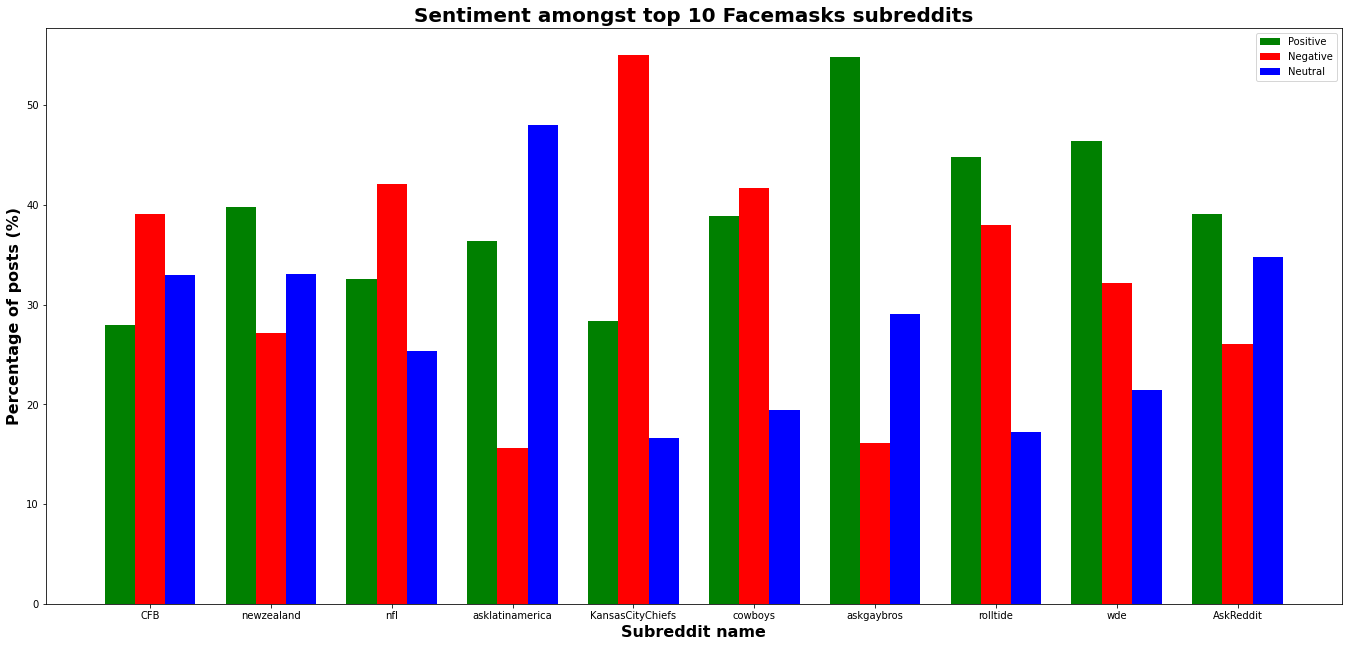

<Figure size 432x288 with 0 Axes>

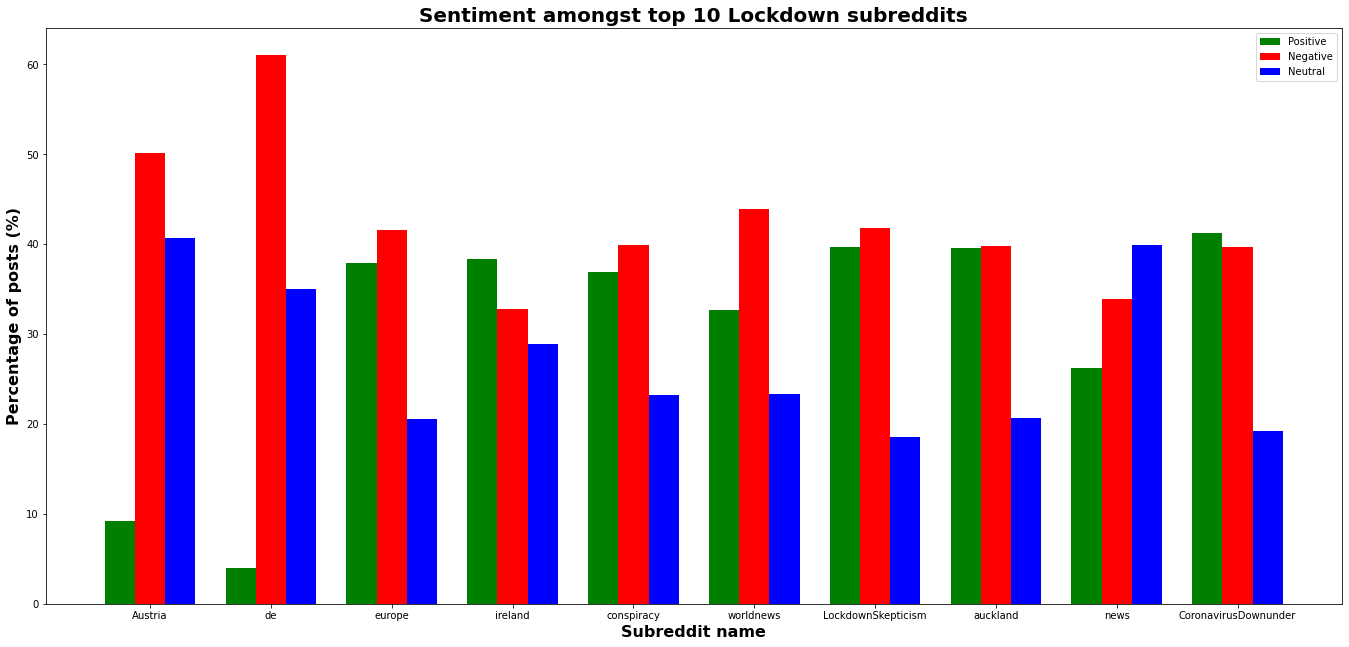

<Figure size 432x288 with 0 Axes>

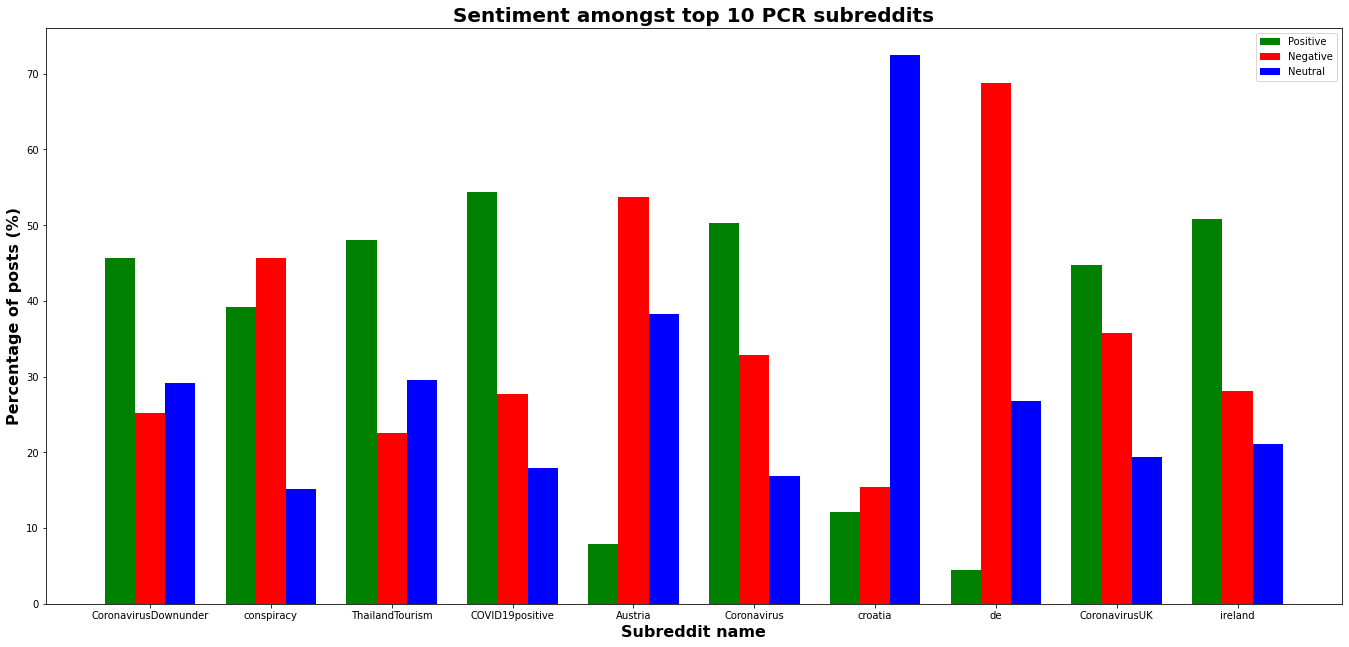

<Figure size 432x288 with 0 Axes>

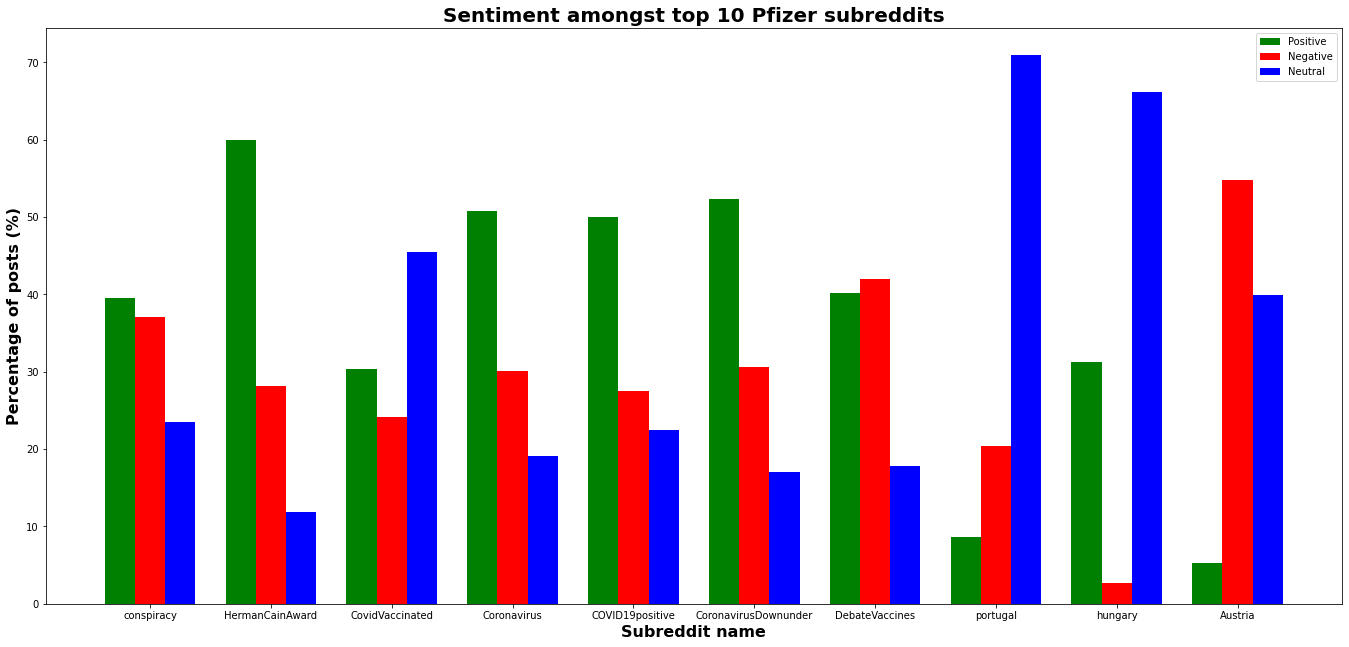

<Figure size 432x288 with 0 Axes>

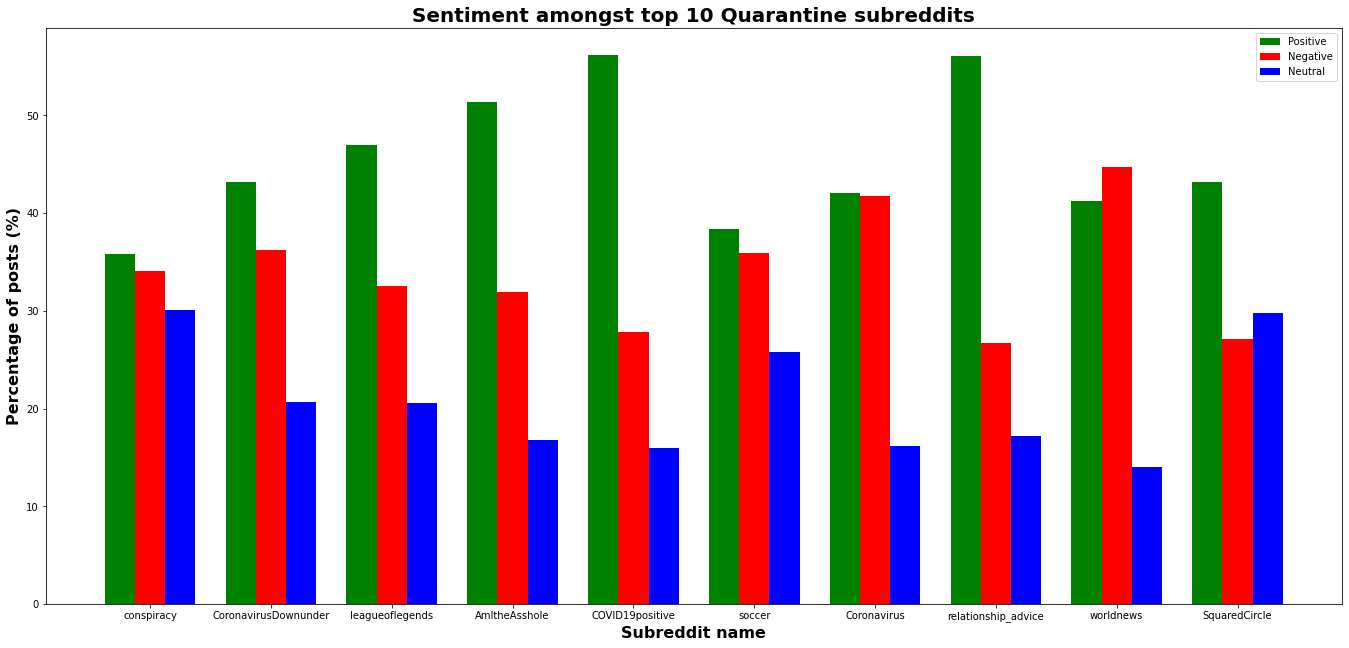

<Figure size 432x288 with 0 Axes>

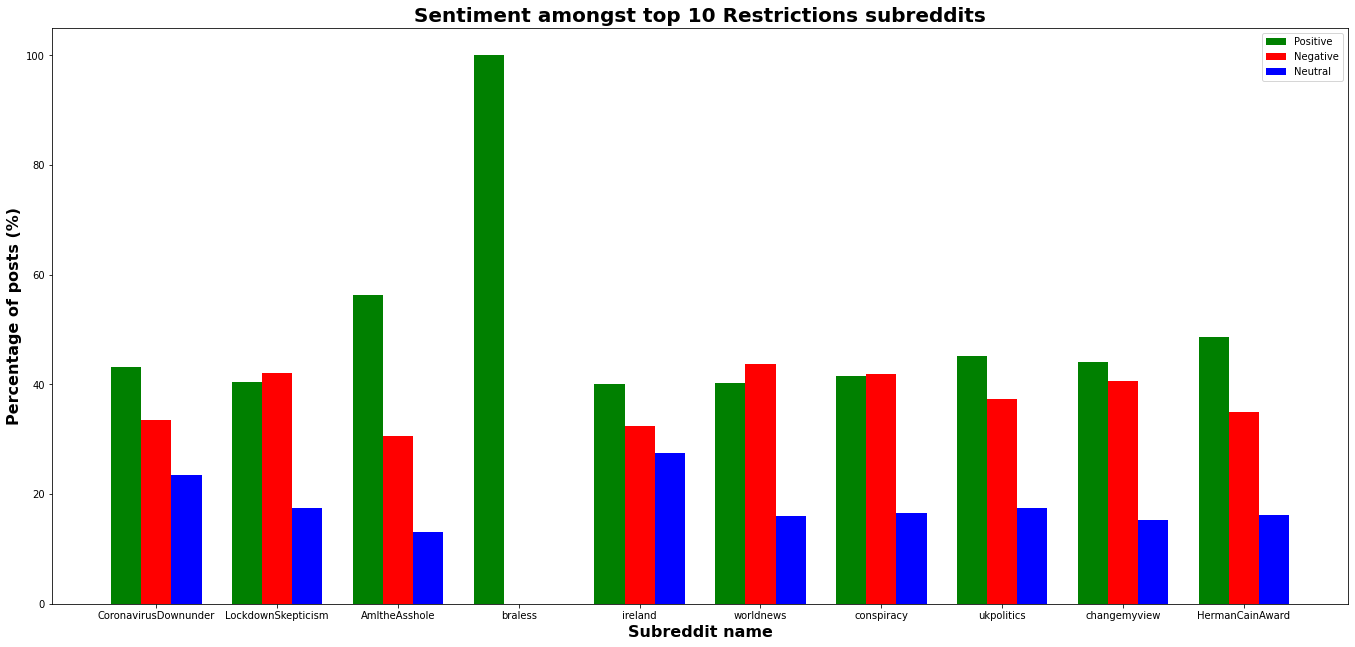

<Figure size 432x288 with 0 Axes>

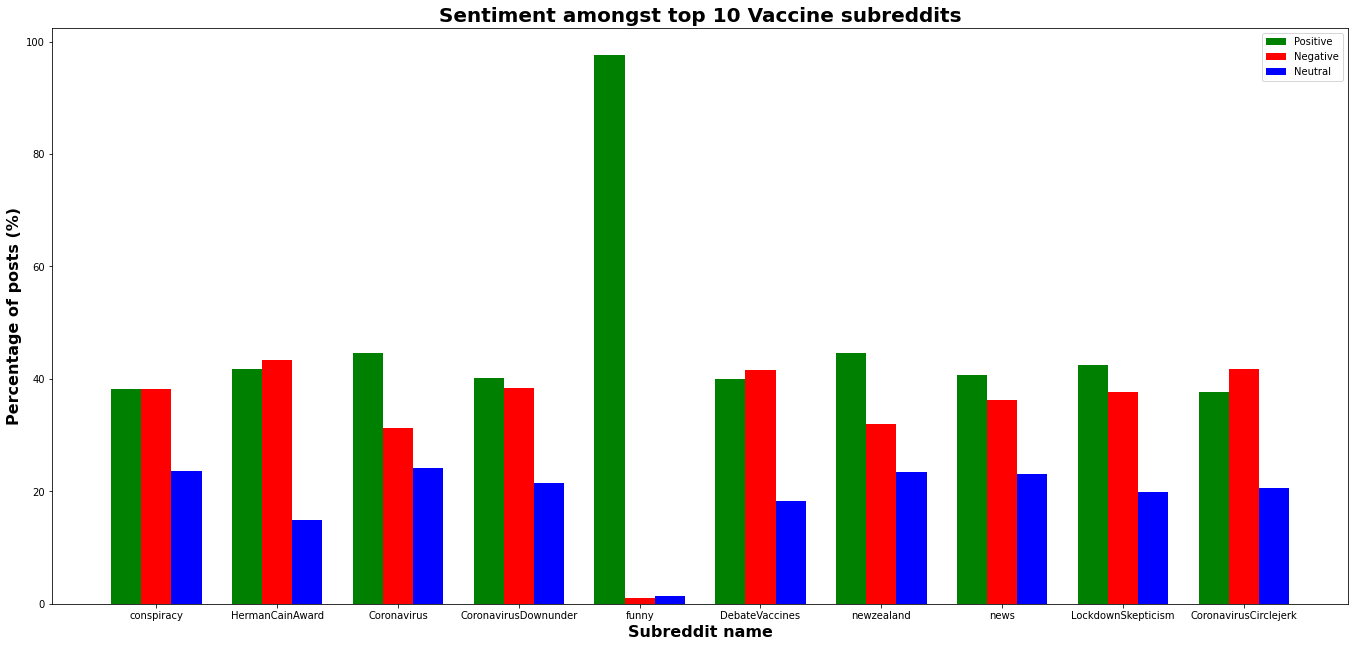

In [55]:
plot_sentiment_top10("Facemasks", fmasks_subr, fmasks_datapts)
plot_sentiment_top10("Lockdown", ldown_subr, ldown_datapts)
plot_sentiment_top10("PCR", pcr_subr, pcr_datapts)
plot_sentiment_top10("Pfizer", pfizer_subr, pfizer_datapts)
plot_sentiment_top10("Quarantine", qtine_subr, qtine_datapts)
plot_sentiment_top10("Restrictions", rtions_subr, rtions_datapts)
plot_sentiment_top10("Vaccine", vac_subr, vac_datapts)

In [56]:
list_of_topics = ['Facemasks', 'Lockdown', 'PCR', 'Pfizer', 'Quarantine', 'Restrictions', 'Vaccine']

In [57]:
def plot_topics(list_of_topics, data_points):
    fig = plt.figure()
    x_point = np.arange(7)
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x_point + 0.00, data_points[0], color = 'g', width = 0.25)
    ax.bar(x_point + 0.25, data_points[1], color = 'r', width = 0.25)
    ax.bar(x_point + 0.50, data_points[2], color = 'b', width = 0.25)
    ax.set_ylabel('Number of posts', fontweight='bold', fontsize=16)
    ax.set_xlabel('Search query', fontweight='bold', fontsize=16)
    ax.set_title("Sentiment amongst reddit queries", fontweight='bold', fontsize=20)
    plt.xticks(x_point + 0.25, list_of_topics)

    ax.legend(labels=['Positive', 'Negative', 'Neutral'])

In [62]:
query_dpts = []
positive = []
negative = []
neutral = []

for sentiment in facemasks_sum, lockdown_sum, pcr_sum, pfizer_sum, quarantine_sum, restrictions_sum, vaccine_sum:
    positive += [sentiment['pos_perc']]
    negative += [sentiment['neg_perc']]
    neutral += [sentiment['neu_perc']]

query_dpts += [positive, negative, neutral]

<Figure size 432x288 with 0 Axes>

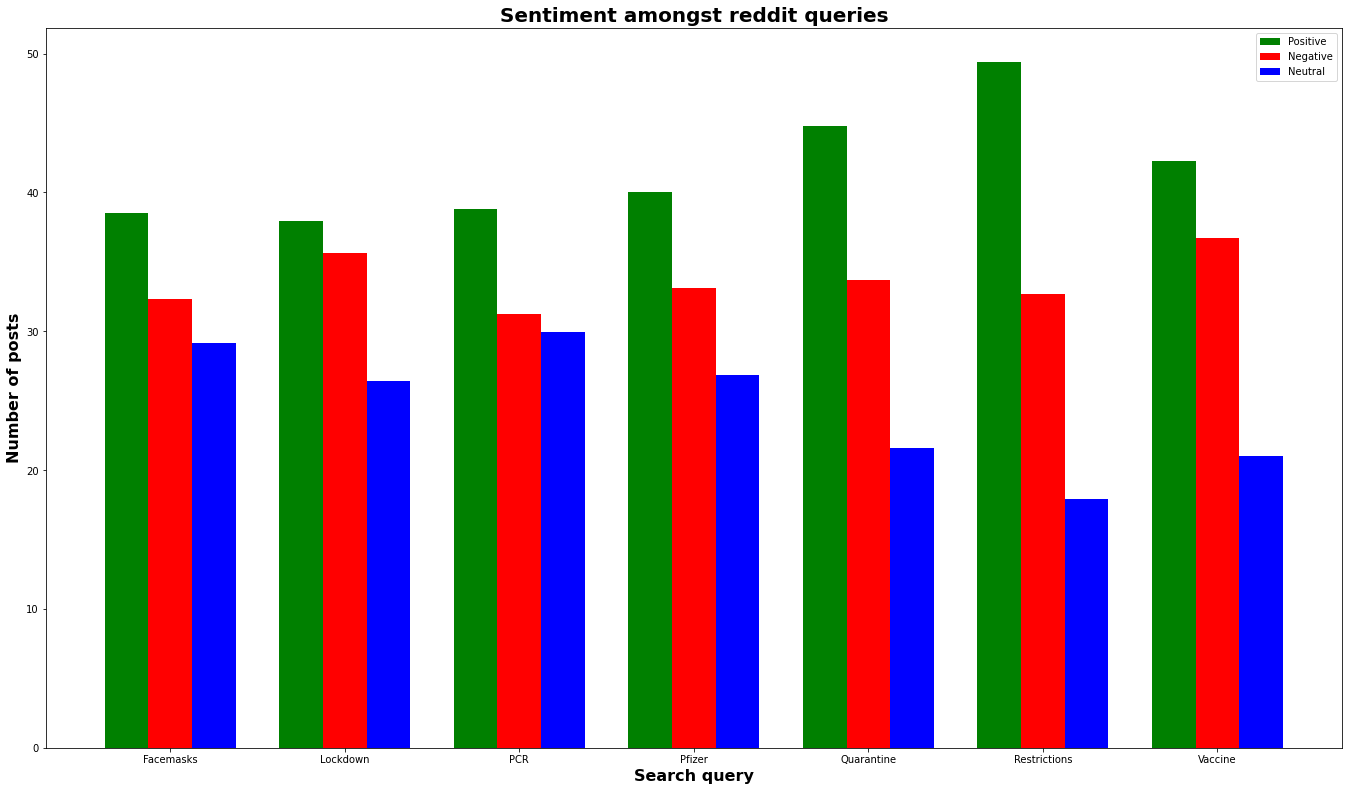

In [63]:
plot_topics(list_of_topics, query_dpts)

In [301]:
subreddit_appearances = {}

for subreddit in fmasks_subr:
    subreddit_appearances[subreddit] = ['Facemasks']

for subreddit in ldown_subr:
    if subreddit in subreddit_appearances:
        subreddit_appearances[subreddit] += ['Lockdown']
    else:
        subreddit_appearances[subreddit] = ['Lockdown']

for subreddit in pcr_subr:
    if subreddit in subreddit_appearances:
        subreddit_appearances[subreddit] += ['PCR']
    else:
        subreddit_appearances[subreddit] = ['PCR']

for subreddit in pfizer_subr:
    if subreddit in subreddit_appearances:
        subreddit_appearances[subreddit] += ['Pfizer']
    else:
        subreddit_appearances[subreddit] = ['Pfizer']

for subreddit in qtine_subr:
    if subreddit in subreddit_appearances:
        subreddit_appearances[subreddit] += ['Quarantine']
    else:
        subreddit_appearances[subreddit] = ['Quarantine']

for subreddit in rtions_subr:
    if subreddit in subreddit_appearances:
        subreddit_appearances[subreddit] += ['Restrictions']
    else:
        subreddit_appearances[subreddit] = ['Restrictions']

for subreddit in vac_subr:
    if subreddit in subreddit_appearances:
        subreddit_appearances[subreddit] += ['Vaccine']
    else:
        subreddit_appearances[subreddit] = ['Vaccine']
    

In [305]:
for subr in subreddit_appearances:
    print(subr, subreddit_appearances[subr])

CFB ['Facemasks']
newzealand ['Facemasks', 'Vaccine']
nfl ['Facemasks']
asklatinamerica ['Facemasks']
KansasCityChiefs ['Facemasks']
cowboys ['Facemasks']
askgaybros ['Facemasks']
rolltide ['Facemasks']
wde ['Facemasks']
AskReddit ['Facemasks']
Austria ['Lockdown', 'PCR', 'Pfizer']
de ['Lockdown', 'PCR']
europe ['Lockdown']
ireland ['Lockdown', 'PCR', 'Restrictions']
conspiracy ['Lockdown', 'PCR', 'Pfizer', 'Quarantine', 'Restrictions', 'Vaccine']
worldnews ['Lockdown', 'Quarantine', 'Restrictions']
LockdownSkepticism ['Lockdown', 'Restrictions', 'Vaccine']
auckland ['Lockdown']
news ['Lockdown', 'Vaccine']
CoronavirusDownunder ['Lockdown', 'PCR', 'Pfizer', 'Quarantine', 'Restrictions', 'Vaccine']
ThailandTourism ['PCR']
COVID19positive ['PCR', 'Pfizer', 'Quarantine']
Coronavirus ['PCR', 'Pfizer', 'Quarantine', 'Vaccine']
croatia ['PCR']
CoronavirusUK ['PCR']
HermanCainAward ['Pfizer', 'Restrictions', 'Vaccine']
CovidVaccinated ['Pfizer']
DebateVaccines ['Pfizer', 'Vaccine']
portugal [